In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# Load the data


In [2]:
books_df = pd.read_csv('../data/Books.csv', delimiter=';', low_memory=False)
ratings_df = pd.read_csv('../data/Ratings.csv', delimiter=';')
users_df = pd.read_csv('../data/Users.csv', delimiter=';')

/var/folders/s0/4m_t_82936ggv17n0g0t7_dr0000gn/T/ipykernel_80013/4047143737.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  users_df = pd.read_csv('../data/Users.csv', delimiter=';')


# Preprocess the data

In [3]:
ratings_df = ratings_df[ratings_df['Rating'] > 0]

ratings_df['User-ID'] = ratings_df['User-ID']
ratings_df['ISBN'] = ratings_df['ISBN']
ratings_df['Rating'] = ratings_df['Rating']

data = pd.merge(ratings_df, books_df, on='ISBN')

# Epsilon Greedy / UCB Algorithms

In [4]:
class EpsilonGreedyMAB:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self.book_rewards = {}
        self.book_counts = {}

    def select_book(self, book_list):
        if np.random.rand() < self.epsilon:
            # explore: select a random book
            return np.random.choice(book_list)
        else:
            # exploit: select the book with the highest avg reward
            return max(book_list, key=lambda x: self.book_rewards.get(x, 0) / (self.book_counts.get(x, 1)))

    def update(self, book, reward):
        if book in self.book_rewards:
            self.book_rewards[book] += reward
            self.book_counts[book] += 1
        else:
            self.book_rewards[book] = reward
            self.book_counts[book] = 1


In [5]:
class UCBMAB:
    def __init__(self):
        self.book_rewards = {}
        self.book_counts = {}
        self.total_counts = 0

    def select_book(self, book_list):
        selected_book = None
        max_ucb = float('-inf')

        for book in book_list:
            if book not in self.book_rewards:
                return book

            avg_reward = self.book_rewards[book] / self.book_counts[book]
            confidence_bound = np.sqrt(2 * np.log(self.total_counts + 1) / self.book_counts[book])
            ucb = avg_reward + confidence_bound

            if ucb > max_ucb:
                max_ucb = ucb
                selected_book = book

        return selected_book

    def update(self, book, reward):
        self.total_counts += 1
        if book in self.book_rewards:
            self.book_rewards[book] += reward
            self.book_counts[book] += 1
        else:
            self.book_rewards[book] = reward
            self.book_counts[book] = 1


# User intercation simulation

In [6]:
def simulate_user_interaction(user_id, mab):
    # get the books the user has read
    user_mask = (data['User-ID'] == user_id)
    user_books = data[user_mask]['Title'].unique()
    if len(user_books) == 0:
        return None, None
    
    # select a book to recommend
    recommended_book = mab.select_book(user_books)

    # get the actual rating of the recommended book
    book_mask = (data['Title'] == recommended_book)
    actual_rating = data[user_mask & book_mask]['Rating'].values[0]
    
    # update the MAB with the observed reward
    mab.update(recommended_book, actual_rating)

    return recommended_book, actual_rating

In [7]:
# init Epsilon-greedy and UCB MABs
epsilon_mab = EpsilonGreedyMAB(epsilon=0.9)
ucb_mab = UCBMAB()

epsilon_cumulative_rewards = []
ucb_cumulative_rewards = []
epsilon_total_reward = 0
ucb_total_reward = 0

users_num = 200

user_ids = data['User-ID'].unique()[:users_num] 

for user_id in user_ids:
    # Epsilon-Greedy
    recommended_book_epsilon, actual_rating_epsilon = simulate_user_interaction(user_id, epsilon_mab)
    if recommended_book_epsilon:
        epsilon_total_reward += actual_rating_epsilon
        epsilon_cumulative_rewards.append(epsilon_total_reward)
    
    # UCB
    recommended_book_ucb, actual_rating_ucb = simulate_user_interaction(user_id, ucb_mab)
    if recommended_book_ucb:
        ucb_total_reward += actual_rating_ucb
        ucb_cumulative_rewards.append(ucb_total_reward)


# Plot strategy rewards

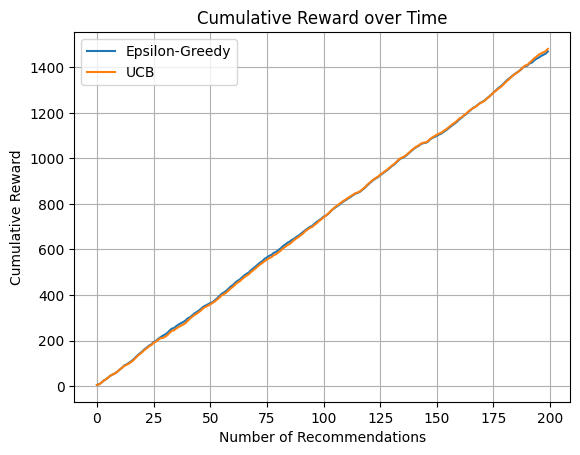

In [8]:
plt.plot(epsilon_cumulative_rewards, label='Epsilon-Greedy')
plt.plot(ucb_cumulative_rewards, label='UCB')

plt.xlabel('Number of Recommendations')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Time')
plt.legend()
plt.grid(True)
plt.show()